# train

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(10)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
means

DeviceArray([[0.9173026 ],
             [0.85924673]], dtype=float32)

In [13]:
covs

DeviceArray([[[0.13958423]],

             [[0.3323139 ]]], dtype=float32)

In [28]:
x0 = np.squeeze(x0)
for x0i in x0:
    if np.isnan(x0i): raise Exception

In [2]:
d = 1
k = 2
*rkeys, rkey = random.split(rkey, 4)

means = random.uniform(rkeys[0], shape=(k, d))
covs = random.uniform(rkeys[1], shape=(k, d, d))
covs = np.einsum("kil,kjl->kij", covs, covs) * 2
# weights = random.dirichlet(rkey[2], alpha=np.ones(k)+1, shape=(k,))
weights = np.ones(k)

dist = metrics.GaussianMixture(means, covs, weights)

n = 300
assert d == dist.d

n_steps = 1000
svgd = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

In [3]:
h = [500] * d
lr = 0.01
svgd_stepsize = 0.01
bandwidth = h
ksd_bandwidth = 1

In [4]:
rkey = random.split(rkey)[0]

### train

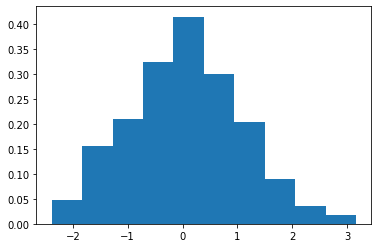

In [17]:
_ = plt.hist(np.squeeze(log_svgd["x0"]), density=True)

In [5]:
st = time.time()
x_svgd, log_svgd, losses = svgd.train(rkey, h, lr, svgd_stepsize, n_steps, ksd_bandwidth, update_after=0)
x_svgd.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")

  0%|          | 1/1000 [00:02<42:16,  2.54s/it]

JIT COMPILING step...
...done compiling step after 0.45383286476135254 seconds.


/home/lauro/code/msc-thesis/svgd/svgd.py:230: RuntimeWarning: NaNs detected in logh at iteration 1. Training interrupted.
  warnings.warn(f"NaNs detected in logh at iteration {i}. Training interrupted.", RuntimeWarning)
  0%|          | 1/1000 [00:05<1:30:41,  5.45s/it]

took 5.735515594482422 seconds


JIT COMPILING svgd...
...done compiling svgd after 0.761439323425293 seconds.
took 5.209069490432739 seconds


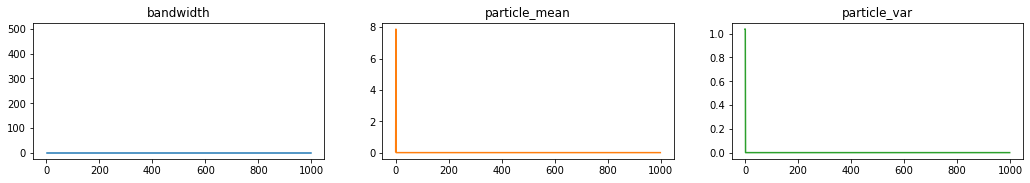

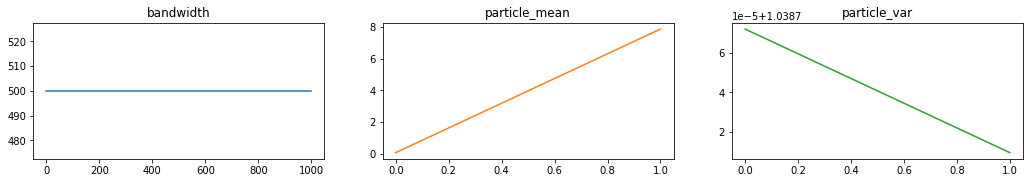

In [6]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, h, n_steps)
end = time.time()
print(f"took {end - st} seconds")

plot.svgd_log(log_svgd)
plot.svgd_log(logs)

In [7]:
log_svgd["desc"]["bandwidth"][-3:]

DeviceArray([[0.],
             [0.],
             [0.]], dtype=float32)

# Metrics

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

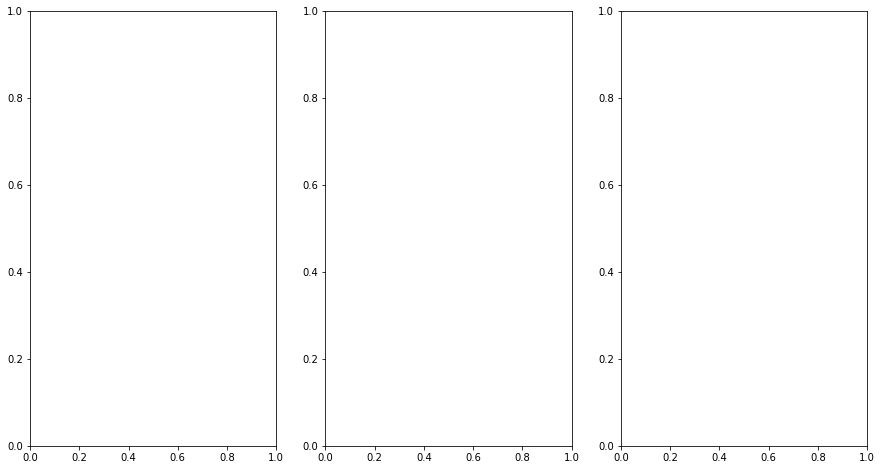

In [8]:
s = dist.sample(shape=(n,))
plot.bivariate_hist(s)

In [ ]:
xlearned, xfix, xsample = x_svgd, xs, s

In [ ]:
def set_axhlines(ax, ys):
    """Paint len(ys) segmented horizontal lines"""
    try:
        ns = len(ys)
    except TypeError:
        ns = 1
        ys = [ys]
    grid = np.linspace(0, 1, num=ns+1)
    
    for i, y in enumerate(ys):
        ax.axhline(y, xmin=grid[i], xmax=grid[i+1], color="k", linestyle="--", linewidth=2.5)

for key, titles in dist.metric_names.items():
    fig, axes = plt.subplots(1, 4, figsize=(2*4*3, 4))
    data = [dist.compute_metrics(out)[key] for out in (xlearned, xfix, xsample)]
    
    for  ax, title, *dat in zip(axes, titles, *data):
        sample = dat[-1]
        dat = np.array(dat[:-1])

        plot.make_bar_chart(dat, figax=(fig, ax))
        ax.set_title(title)
        set_axhlines(ax, sample)
        ax.set_yscale("log")

# Histograms

## Learned bandwidth

In [ ]:
plot.bivariate_hist(x_svgd)

## Fixed bandwidth

In [ ]:
plot.bivariate_hist(xs)

# compare sample